In [1]:
import pandas as pd
import numpy as np

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [4]:
df = pd.read_csv('../data/winProxy.csv',parse_dates=True,index_col=0)

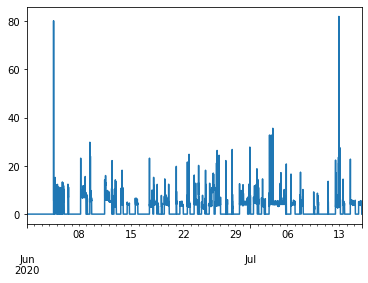

In [5]:
_ = df.CPU.plot()

In [6]:
train_size = round(len(df) * 0.75)

In [7]:
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]
print("Number of training samples",len(train))
print("Number of testing samples",len(test))

Number of training samples 9721
Number of testing samples 3240


The CPU time series will always take values between [0,100]
we are going to generate random numbers in this range.
The probability of any number = probabilty of occurance in the train dataset


In [8]:
np.random.seed(42)
b = np.bincount(train.CPU)

movement = np.random.choice(np.arange(len(b)),
                               len(test),
                               p=b/len(train),
                               replace=True)


In [9]:
predicted = test.CPU+movement

In [10]:
#adding +1 to avoid division by zero errors
mape( test.CPU+1,predicted+1)

138.38193174851085

In [11]:
#adding +1 to avoid division by zero errors
smape( test.CPU+1,predicted+1)

43.041085702630156

In [12]:
forecast = pd.Series([None for _ in range(len(train))]).append(predicted)
forecast.index = df.index

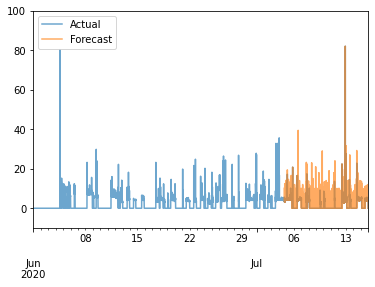

In [16]:
final = pd.concat([df.CPU, forecast], axis=1)
final.rename(columns={'CPU' : 'Actual',0 : 'Forecast'},inplace=True)
axes = final.plot(alpha = 0.65)
a = axes.set_ylim(-10,100)
